In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!unzip /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE_CORROSION.zip -d /content/drive/MyDrive/internship/material_corrosion/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I179_steel_mill-finish_spray-zinc-phosphate-wo-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I209_steel_mill-finish_chromated-wash-primer_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I214_steel-(high-hard)_abrasive-blasted_spray-zinc-phosphate-w-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I221_steel-(high-hard)_abrasive-blasted_immersion-zinc-phosphate-w-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/

# Data Preprocessing and Augmentation

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for fold in range(1, 11):
  train_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/train'
  val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'

  train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transform)
  val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  print(f"Fold {fold}:")
  print(f"  Training set size: {len(train_loader.dataset)}")
  print(f"  Validation set size: {len(val_loader.dataset)}")


Fold 1:
  Training set size: 479
  Validation set size: 61
Fold 2:
  Training set size: 479
  Validation set size: 61
Fold 3:
  Training set size: 479
  Validation set size: 61
Fold 4:
  Training set size: 479
  Validation set size: 61
Fold 5:
  Training set size: 479
  Validation set size: 61
Fold 6:
  Training set size: 479
  Validation set size: 61
Fold 7:
  Training set size: 479
  Validation set size: 61
Fold 8:
  Training set size: 479
  Validation set size: 61
Fold 9:
  Training set size: 479
  Validation set size: 61
Fold 10:
  Training set size: 479
  Validation set size: 61


# ResNet-18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100 * correct / total
  return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          running_loss += loss.item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100 * correct / total
  return epoch_loss, epoch_acc

# Cross-Validation and Training

In [ ]:
num_epochs = 10
for fold in range(1, 11):
  print(f"\Training for Fold {fold}...")

  train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  model = models.resnet18(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, 5)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate_model(val_loader, model, criterion, device)
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth')
  print(f"Fold {fold} completed.")

\Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
  Training Loss: 1.2784, Training Accuracy: 47.60%
  Validation Loss: 2.9191, Validation Accuracy: 44.26%
Epoch 2/10
  Training Loss: 0.9626, Training Accuracy: 59.08%
  Validation Loss: 1.2229, Validation Accuracy: 52.46%
Epoch 3/10
  Training Loss: 0.8203, Training Accuracy: 64.93%
  Validation Loss: 0.8982, Validation Accuracy: 57.38%
Epoch 4/10
  Training Loss: 0.7322, Training Accuracy: 74.74%
  Validation Loss: 0.8275, Validation Accuracy: 68.85%
Epoch 5/10
  Training Loss: 0.8160, Training Accuracy: 65.76%
  Validation Loss: 0.7592, Validation Accuracy: 68.85%
Epoch 6/10
  Training Loss: 0.7225, Training Accuracy: 72.03%
  Validation Loss: 0.9325, Validation Accuracy: 59.02%
Epoch 7/10
  Training Loss: 0.6989, Training Accuracy: 72.86%
  Validation Loss: 0.8428, Validation Accuracy: 65.57%
Epoch 8/10
  Training Loss: 0.6435, Training Accuracy: 73.49%
  Validation Loss: 0.8576, Validation Accuracy: 63.93%
Epoch 9/10
  Training Loss: 0.6851, Training Accuracy: 73.90%
  

# Model Evaluation

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

fold = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
model.to(device)
model.eval()


<ipython-input-8-363be42a651e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resne

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.57


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)


              precision    recall  f1-score   support

     Class 1       0.58      0.92      0.71        12
     Class 2       1.00      0.25      0.40        12
     Class 3       0.39      0.54      0.45        13
     Class 4       0.67      0.17      0.27        12
     Class 5       0.67      1.00      0.80        12

    accuracy                           0.57        61
   macro avg       0.66      0.57      0.53        61
weighted avg       0.66      0.57      0.52        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[11  0  1  0  0]
 [ 6  3  3  0  0]
 [ 2  0  7  1  3]
 [ 0  0  7  2  3]
 [ 0  0  0  0 12]]


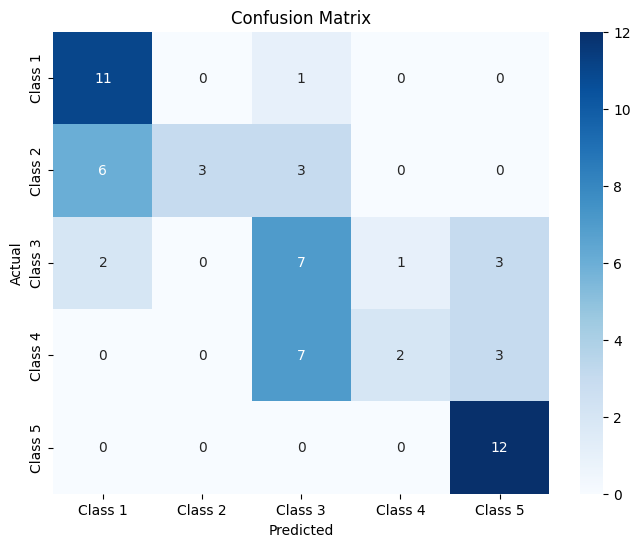

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import json

metrics = {
    "accuracy": accuracy,
    "classification_report": classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], output_dict=True),
    "confusion_matrix": conf_matrix.tolist()
}

with open('/content/drive/MyDrive/internship/material_corrosion/metrics.json', 'w') as f:
    json.dump(metrics, f)


#Increasing epochs for training

In [ ]:

num_epochs = 30
for fold in range(1, 11):
  print(f"\Training for Fold {fold}...")

  train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  model = models.resnet18(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, 5)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate_model(val_loader, model, criterion, device)
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth')
  print(f"Fold {fold} completed.")

\Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 1/30
  Training Loss: 1.3057, Training Accuracy: 48.85%
  Validation Loss: 7.5078, Validation Accuracy: 40.98%
Epoch 2/30
  Training Loss: 0.9825, Training Accuracy: 59.71%
  Validation Loss: 1.9093, Validation Accuracy: 45.90%
Epoch 3/30
  Training Loss: 0.9023, Training Accuracy: 61.59%
  Validation Loss: 0.9918, Validation Accuracy: 62.30%
Epoch 4/30
  Training Loss: 0.8097, Training Accuracy: 68.89%
  Validation Loss: 0.6026, Validation Accuracy: 67.21%
Epoch 5/30
  Training Loss: 0.7592, Training Accuracy: 70.35%
  Validation Loss: 0.9515, Validation Accuracy: 57.38%
Epoch 6/30
  Training Loss: 0.7850, Training Accuracy: 69.10%
  Validation Loss: 0.8677, Validation Accuracy: 70.49%
Epoch 7/30
  Training Loss: 0.7095, Training Accuracy: 69.73%
  Validation Loss: 1.1801, Validation Accuracy: 49.18%
Epoch 8/30
  Training Loss: 0.7158, Training Accuracy: 70.56%
  Validation Loss: 0.7882, Validation Accuracy: 68.85%
Epoch 9/30
  Training Loss: 0.7218, Training Accuracy: 73.07%
  

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

fold = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
model.to(device)
model.eval()


<ipython-input-4-c30c62f36dfe>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resne

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.74


Precision, Recall, F1-Score


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       0.92      1.00      0.96        12
     Class 2       0.90      0.75      0.82        12
     Class 3       0.55      0.46      0.50        13
     Class 4       0.50      0.75      0.60        12
     Class 5       1.00      0.75      0.86        12

    accuracy                           0.74        61
   macro avg       0.77      0.74      0.75        61
weighted avg       0.77      0.74      0.74        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[12  0  0  0  0]
 [ 1  9  2  0  0]
 [ 0  1  6  6  0]
 [ 0  0  3  9  0]
 [ 0  0  0  3  9]]


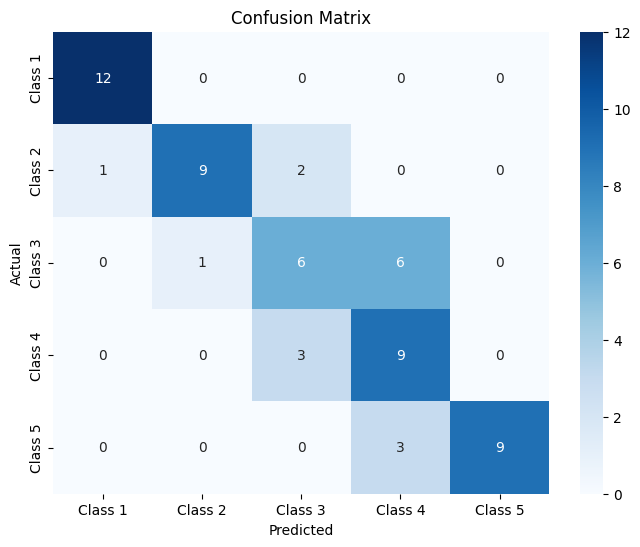

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import json

metrics = {
    "accuracy": accuracy,
    "classification_report": classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], output_dict=True),
    "confusion_matrix": conf_matrix.tolist()
}

with open('/content/drive/MyDrive/internship/material_corrosion/metrics.json', 'w') as f:
    json.dump(metrics, f)

Classes 3 and 4 (levels 7,8) are the most similar and keep having the worst accuracy

# Increasing to 50 epochs

In [ ]:

num_epochs = 50
for fold in range(1, 11):
  print(f"\Training for Fold {fold}...")

  train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  model = models.resnet18(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, 5)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate_model(val_loader, model, criterion, device)
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth')
  print(f"Fold {fold} completed.")

\Training for Fold 1...
Epoch 1/50
  Training Loss: 1.2200, Training Accuracy: 54.91%
  Validation Loss: 6.5889, Validation Accuracy: 32.79%
Epoch 2/50
  Training Loss: 1.0144, Training Accuracy: 60.54%
  Validation Loss: 3.9610, Validation Accuracy: 31.15%
Epoch 3/50
  Training Loss: 0.8595, Training Accuracy: 60.33%
  Validation Loss: 0.8313, Validation Accuracy: 63.93%
Epoch 4/50
  Training Loss: 0.8224, Training Accuracy: 65.14%
  Validation Loss: 1.9771, Validation Accuracy: 37.70%
Epoch 5/50
  Training Loss: 0.7807, Training Accuracy: 68.48%
  Validation Loss: 0.8966, Validation Accuracy: 62.30%
Epoch 6/50
  Training Loss: 0.6986, Training Accuracy: 72.23%
  Validation Loss: 0.9325, Validation Accuracy: 63.93%
Epoch 7/50
  Training Loss: 0.6386, Training Accuracy: 74.74%
  Validation Loss: 0.8117, Validation Accuracy: 63.93%
Epoch 8/50
  Training Loss: 0.7116, Training Accuracy: 72.44%
  Validation Loss: 1.1521, Validation Accuracy: 55.74%
Epoch 9/50
  Training Loss: 0.6529, Trai

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

fold = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
model.to(device)
model.eval()

<ipython-input-39-c30c62f36dfe>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.67


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      0.67      0.80        12
     Class 2       0.71      0.83      0.77        12
     Class 3       0.44      0.54      0.48        13
     Class 4       0.56      0.42      0.48        12
     Class 5       0.79      0.92      0.85        12

    accuracy                           0.67        61
   macro avg       0.70      0.67      0.67        61
weighted avg       0.69      0.67      0.67        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 8  3  1  0  0]
 [ 0 10  2  0  0]
 [ 0  1  7  3  2]
 [ 0  0  6  5  1]
 [ 0  0  0  1 11]]


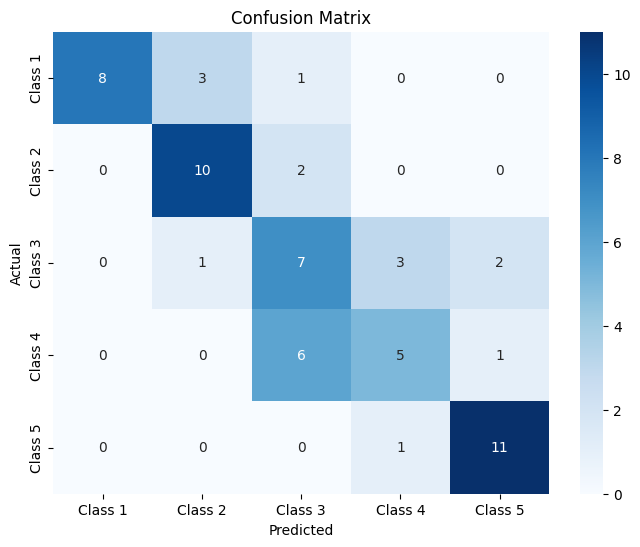

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

worse results than with 30 epochs

# ResNet18 Model Testing

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = '/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

for fold in range(1, 11):
    print(f"Evaluating Fold {fold}...")

    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
    model.eval()
    model.to(device)

    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy (averaged over 10 folds): {accuracy*100:.2f}%")
print(f"Precision (averaged over 10 folds): {precision:.2f}")
print(f"Recall (averaged over 10 folds): {recall:.2f}")
print(f"F1 Score (averaged over 10 folds): {f1:.2f}")
print("Confusion Matrix (averaged over 10 folds):")
print(cm)


Evaluating Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-45-12c747c6e24b>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Evaluating Fold 10...
Test Accuracy (averaged over 10 folds): 71.50%
Precision (averaged over 10 folds): 0.74
Recall (averaged over 10 folds): 0.71
F1 Score (averaged over 10 folds): 0.72
Confusion Matrix (averaged over 10 folds):
[[ 91  19  10   0   0]
 [ 24  65  17  10   4]
 [  0   1  73  43   3]
 [  0   0  13 104   3]
 [  0   0   0  24  96]]


# ResNet-50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Cross-validation and Training

In [ ]:
num_epochs = 30
for fold in range(1, 11):
  print(f"\nTraining for Fold {fold}...")

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  model = models.resnet50(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, 5)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate_model(val_loader, model, criterion, device)
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet50_fold_{fold}.pth')
  print(f"Fold {fold} completed.")



Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


Epoch 1/30
  Training Loss: 1.3555, Training Accuracy: 47.60%
  Validation Loss: 8.8349, Validation Accuracy: 36.07%
Epoch 2/30
  Training Loss: 1.0413, Training Accuracy: 58.25%
  Validation Loss: 10.6607, Validation Accuracy: 29.51%
Epoch 3/30
  Training Loss: 0.8751, Training Accuracy: 62.21%
  Validation Loss: 1.0260, Validation Accuracy: 59.02%
Epoch 4/30
  Training Loss: 0.9051, Training Accuracy: 64.51%
  Validation Loss: 0.9805, Validation Accuracy: 63.93%
Epoch 5/30
  Training Loss: 0.8184, Training Accuracy: 65.55%
  Validation Loss: 0.8546, Validation Accuracy: 57.38%
Epoch 6/30
  Training Loss: 0.7743, Training Accuracy: 65.55%
  Validation Loss: 0.9762, Validation Accuracy: 67.21%
Epoch 7/30
  Training Loss: 0.7647, Training Accuracy: 68.48%
  Validation Loss: 0.8841, Validation Accuracy: 60.66%
Epoch 8/30
  Training Loss: 0.7040, Training Accuracy: 70.35%
  Validation Loss: 0.8020, Validation Accuracy: 60.66%
Epoch 9/30
  Training Loss: 0.7561, Training Accuracy: 69.94%
 

# Model Evaluation

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

fold = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet50_fold_{fold}.pth'))
model.to(device)
model.eval()

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


<ipython-input-7-37bee7c90a47>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

# Metrics

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       0.82      0.75      0.78        12
     Class 2       0.90      0.75      0.82        12
     Class 3       0.60      0.46      0.52        13
     Class 4       0.57      0.67      0.62        12
     Class 5       0.75      1.00      0.86        12

    accuracy                           0.72        61
   macro avg       0.73      0.73      0.72        61
weighted avg       0.73      0.72      0.72        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 9  1  2  0  0]
 [ 1  9  1  1  0]
 [ 1  0  6  5  1]
 [ 0  0  1  8  3]
 [ 0  0  0  0 12]]


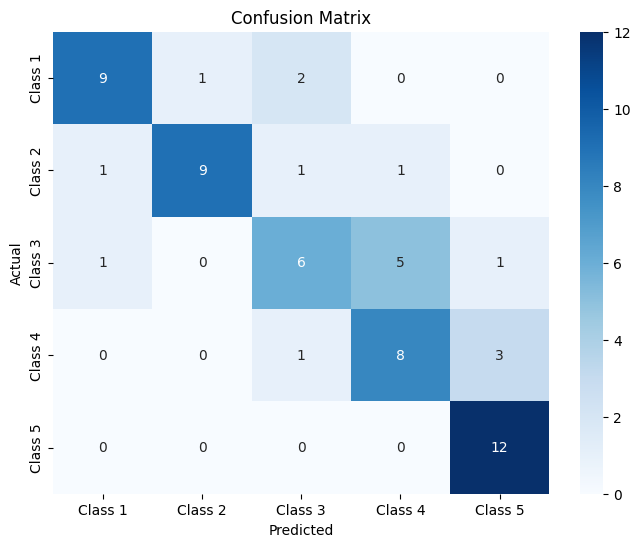

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ResNet50 Model Testing

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = '/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

for fold in range(1, 11):
    print(f"Evaluating Fold {fold}...")

    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet50_fold_{fold}.pth'))
    model.eval()
    model.to(device)

    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy (averaged over 10 folds): {accuracy*100:.2f}%")
print(f"Precision (averaged over 10 folds): {precision:.2f}")
print(f"Recall (averaged over 10 folds): {recall:.2f}")
print(f"F1 Score (averaged over 10 folds): {f1:.2f}")
print("Confusion Matrix (averaged over 10 folds):")
print(cm)


Evaluating Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-12-27dfd9ff48ec>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Evaluating Fold 10...
Test Accuracy (averaged over 10 folds): 74.17%
Precision (averaged over 10 folds): 0.76
Recall (averaged over 10 folds): 0.74
F1 Score (averaged over 10 folds): 0.74
Confusion Matrix (averaged over 10 folds):
[[ 97  18   5   0   0]
 [ 17  74  20   8   1]
 [  2  10  74  34   0]
 [  0   0   6 110   4]
 [  0   0   2  28  90]]


# ResNet-18 Class Balancing with Weighted Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Calculate class weights
def calculate_class_weights(train_loader):
    class_counts = Counter()
    for inputs, labels in train_loader:
        labels = labels.numpy()
        class_counts.update(labels)

    total_samples = sum(class_counts.values())

    class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}

    total_weight = sum(class_weights.values())
    normalized_weights = {class_id: weight / total_weight for class_id, weight in class_weights.items()}

    return normalized_weights

# Step 2: Modify the training function to use weighted loss
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 1: Calculate class weights
def calculate_class_weights(train_loader):
    class_counts = Counter()
    for inputs, labels in train_loader:
        labels = labels.numpy()
        class_counts.update(labels)

    total_samples = sum(class_counts.values())

    class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}

    total_weight = sum(class_weights.values())
    normalized_weights = {class_id: weight / total_weight for class_id, weight in class_weights.items()}

    return normalized_weights

# Step 2: Modify the training function to use weighted loss
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 30
for fold in range(1, 11):
    print(f"\nTraining for Fold {fold}...")

    train_loader = DataLoader(datasets.ImageFolder(root=train_folder, transform=transform_train), batch_size=32, shuffle=True)  # Apply transform here
    val_loader = DataLoader(datasets.ImageFolder(root=val_folder, transform=transform_val), batch_size=32, shuffle=False)  # Apply transform here

    class_weights = calculate_class_weights(train_loader)
    weights = torch.tensor([class_weights[i] for i in range(5)], dtype=torch.float32).to(device)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 5)  # Modify the final layer to match your number of classes
    model.to(device)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers

    # Unfreeze the final fully connected layer to allow fine-tuning
    for param in model.fc.parameters():
        param.requires_grad = True

    # Optionally, unfreeze some deeper layers (for more fine-tuning)
    # Unfreeze some layers (e.g., layers before the final fully connected layer)
    for param in model.layer4.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0001)

    criterion = nn.CrossEntropyLoss(weight=weights)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        val_loss, val_acc = validate_model(val_loader, model, criterion, device)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Step the scheduler
        scheduler.step()

    torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_fine_tuned.pth')
    print(f"Fold {fold} completed.")


Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
  Training Loss: 1.3392, Training Accuracy: 51.57%
  Validation Loss: 4.5191, Validation Accuracy: 45.90%
Epoch 2/30
  Training Loss: 0.9587, Training Accuracy: 58.25%
  Validation Loss: 1.0270, Validation Accuracy: 65.57%
Epoch 3/30
  Training Loss: 0.8571, Training Accuracy: 64.30%
  Validation Loss: 0.6043, Validation Accuracy: 77.05%
Epoch 4/30
  Training Loss: 0.7122, Training Accuracy: 70.98%
  Validation Loss: 0.7030, Validation Accuracy: 70.49%
Epoch 5/30
  Training Loss: 0.7005, Training Accuracy: 70.56%
  Validation Loss: 0.5245, Validation Accuracy: 75.41%
Epoch 6/30
  Training Loss: 0.7012, Training Accuracy: 72.03%
  Validation Loss: 0.6285, Validation Accuracy: 75.41%
Epoch 7/30
  Training Loss: 0.6614, Training Accuracy: 72.44%
  Validation Loss: 0.6171, Validation Accuracy: 77.05%
Epoch 8/30
  Training Loss: 0.6336, Training Accuracy: 73.49%
  Validation Loss: 0.6071, Validation Accuracy: 67.21%
Epoch 9/30
  Training Loss: 0.6201, Training Accuracy: 74.74%
  

# Model Evaluation

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold in range(1, 11):
    print(f"Evaluating for Fold {fold}...")

    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
    model.to(device)
    model.eval()

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
    val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

Evaluating for Fold 1...


<ipython-input-15-95da11cd45ec>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Evaluating for Fold 2...
Evaluating for Fold 3...
Evaluating for Fold 4...
Evaluating for Fold 5...
Evaluating for Fold 6...
Evaluating for Fold 7...
Evaluating for Fold 8...
Evaluating for Fold 9...
Evaluating for Fold 10...


# Metrics


Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.82


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00        12
     Class 2       1.00      0.75      0.86        12
     Class 3       0.67      0.62      0.64        13
     Class 4       0.61      0.92      0.73        12
     Class 5       1.00      0.83      0.91        12

    accuracy                           0.82        61
   macro avg       0.86      0.82      0.83        61
weighted avg       0.85      0.82      0.82        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[12  0  0  0  0]
 [ 0  9  3  0  0]
 [ 0  0  8  5  0]
 [ 0  0  1 11  0]
 [ 0  0  0  2 10]]


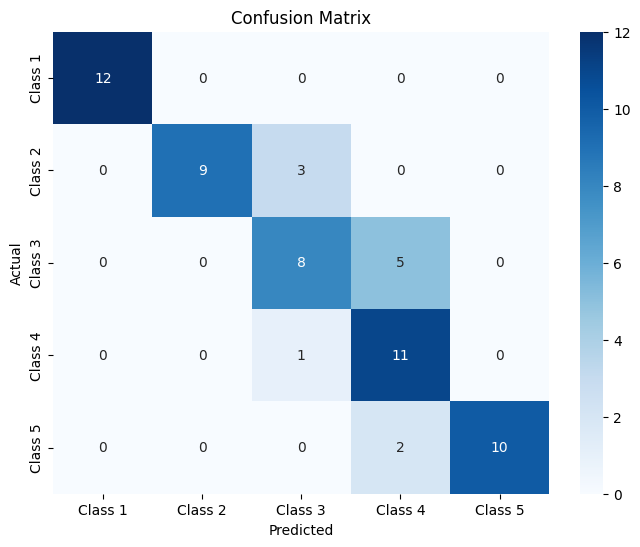

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = '/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

for fold in range(1, 11):
    print(f"Evaluating Fold {fold}...")

    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
    model.eval()
    model.to(device)

    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy (averaged over 10 folds): {accuracy*100:.2f}%")
print(f"Precision (averaged over 10 folds): {precision:.2f}")
print(f"Recall (averaged over 10 folds): {recall:.2f}")
print(f"F1 Score (averaged over 10 folds): {f1:.2f}")
print("Confusion Matrix (averaged over 10 folds):")
print(cm)

Evaluating Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-20-1d74971e5195>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Evaluating Fold 10...
Test Accuracy (averaged over 10 folds): 69.83%
Precision (averaged over 10 folds): 0.73
Recall (averaged over 10 folds): 0.70
F1 Score (averaged over 10 folds): 0.70
Confusion Matrix (averaged over 10 folds):
[[ 92  23   5   0   0]
 [ 24  75   9  10   2]
 [  1  15  72  32   0]
 [  0   1  19 100   0]
 [  2   3   1  34  80]]


# Label Smoothing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def label_smoothing_loss(predictions, targets, smoothing=0.1):
    num_classes = predictions.size(1)
    confidence = 1.0 - smoothing
    smooth_value = smoothing / num_classes

    with torch.no_grad():
        true_dist = torch.zeros_like(predictions)
        true_dist.fill_(smooth_value)
        true_dist.scatter_(1, targets.unsqueeze(1), confidence)

    return torch.mean(torch.sum(-true_dist * nn.functional.log_softmax(predictions, dim=1), dim=1))

def train_model(train_loader, model, optimizer, device, smoothing=0.1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = label_smoothing_loss(outputs, labels, smoothing=smoothing)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(val_loader, model, device, smoothing=0.1):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = label_smoothing_loss(outputs, labels, smoothing=smoothing)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def main(train_loader, val_loader):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 30
smoothing = 0.1

for fold in range(1, 11):
    print(f"\nTraining for Fold {fold}...")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(train_loader, model, optimizer, device, smoothing=smoothing)
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        val_loss, val_acc = validate_model(val_loader, model, device, smoothing=smoothing)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth')
    print(f"Fold {fold} completed.")



Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch 1/30
  Training Loss: 1.4400, Training Accuracy: 42.38%
  Validation Loss: 2.1222, Validation Accuracy: 42.62%
Epoch 2/30
  Training Loss: 1.1080, Training Accuracy: 56.78%
  Validation Loss: 1.4534, Validation Accuracy: 49.18%
Epoch 3/30
  Training Loss: 1.0131, Training Accuracy: 65.76%
  Validation Loss: 0.9750, Validation Accuracy: 73.77%
Epoch 4/30
  Training Loss: 0.9435, Training Accuracy: 68.68%
  Validation Loss: 1.0820, Validation Accuracy: 57.38%
Epoch 5/30
  Training Loss: 0.9117, Training Accuracy: 73.07%
  Validation Loss: 1.3886, Validation Accuracy: 54.10%
Epoch 6/30
  Training Loss: 1.0041, Training Accuracy: 64.51%
  Validation Loss: 1.1669, Validation Accuracy: 60.66%
Epoch 7/30
  Training Loss: 0.9373, Training Accuracy: 69.73%
  Validation Loss: 1.3503, Validation Accuracy: 54.10%
Epoch 8/30
  Training Loss: 0.9013, Training Accuracy: 71.82%
  Validation Loss: 0.9821, Validation Accuracy: 68.85%
Epoch 9/30
  Training Loss: 0.9063, Training Accuracy: 71.82%
  

# Model Evaluation

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold in range(1, 11):
    print(f"Evaluating for Fold {fold}...")

    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
    model.to(device)
    model.eval()

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
    val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

Evaluating for Fold 1...


<ipython-input-15-967a428f977a>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 2...
Evaluating for Fold 3...
Evaluating for Fold 4...
Evaluating for Fold 5...
Evaluating for Fold 6...
Evaluating for Fold 7...
Evaluating for Fold 8...
Evaluating for Fold 9...
Evaluating for Fold 10...


# Metrics

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      0.75      0.86        12
     Class 2       0.83      0.83      0.83        12
     Class 3       0.53      0.69      0.60        13
     Class 4       0.58      0.58      0.58        12
     Class 5       0.91      0.83      0.87        12

    accuracy                           0.74        61
   macro avg       0.77      0.74      0.75        61
weighted avg       0.77      0.74      0.75        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 9  2  1  0  0]
 [ 0 10  2  0  0]
 [ 0  0  9  3  1]
 [ 0  0  5  7  0]
 [ 0  0  0  2 10]]


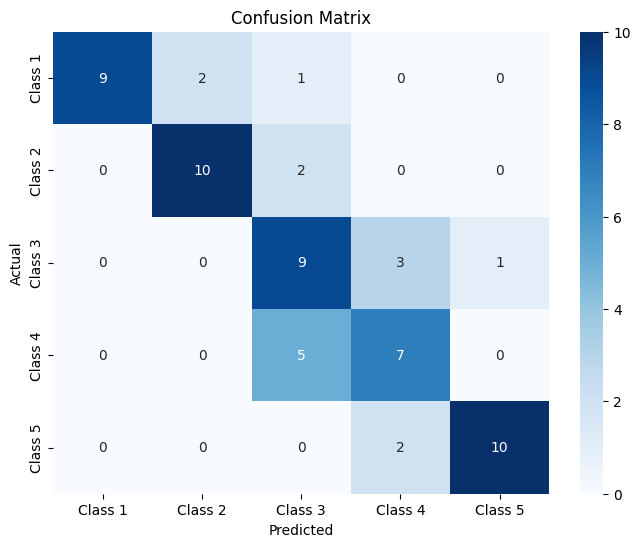

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = '/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []
all_cm = np.zeros((5, 5))

for fold in range(1, 11):
    print(f"Evaluating Fold {fold}...")

    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}.pth'))
    model.eval()
    model.to(device)

    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(fold_labels, fold_preds)
    precision = precision_score(fold_labels, fold_preds, average='weighted')
    recall = recall_score(fold_labels, fold_preds, average='weighted')
    f1 = f1_score(fold_labels, fold_preds, average='weighted')
    cm = confusion_matrix(fold_labels, fold_preds)

    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)
    all_cm += cm

    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold} Precision: {precision:.4f}")
    print(f"Fold {fold} Recall: {recall:.4f}")
    print(f"Fold {fold} F1 Score: {f1:.4f}")
    print(f"Confusion Matrix for Fold {fold}:\n{cm}")
    print("-" * 50)

# Aggregate metrics over all folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)
mean_f1 = np.mean(fold_f1s)

# Normalize the confusion matrix
all_cm = all_cm / all_cm.sum(axis=1, keepdims=True)

print(f"Average Accuracy over 10 folds: {mean_accuracy:.4f}")
print(f"Average Precision over 10 folds: {mean_precision:.4f}")
print(f"Average Recall over 10 folds: {mean_recall:.4f}")
print(f"Average F1 Score over 10 folds: {mean_f1:.4f}")
print("Normalized Confusion Matrix (averaged over 10 folds):")
print(all_cm)


# Focal Loss

In [ ]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 30
for fold in range(1, 11):
    print(f"\nTraining for Fold {fold}...")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    class_weights = calculate_class_weights(train_loader)
    weights = torch.tensor([class_weights[i] for i in range(5)], dtype=torch.float32).to(device)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Use Focal Loss here instead of CrossEntropyLoss
    alpha = torch.tensor([0.5, 0.5, 1.5, 1.5, 0.5]).to(device)
    gamma = 2.0
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        val_loss, val_acc = validate_model(val_loader, model, criterion, device)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_focal.pth')
    print(f"Fold {fold} completed.")


Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
  Training Loss: 0.7502, Training Accuracy: 42.17%
  Validation Loss: 2.4589, Validation Accuracy: 45.90%
Epoch 2/30
  Training Loss: 0.4419, Training Accuracy: 50.73%
  Validation Loss: 1.4891, Validation Accuracy: 40.98%
Epoch 3/30
  Training Loss: 0.3371, Training Accuracy: 57.62%
  Validation Loss: 0.4748, Validation Accuracy: 45.90%
Epoch 4/30
  Training Loss: 0.3505, Training Accuracy: 55.53%
  Validation Loss: 0.7853, Validation Accuracy: 36.07%
Epoch 5/30
  Training Loss: 0.2916, Training Accuracy: 61.59%
  Validation Loss: 0.3658, Validation Accuracy: 49.18%
Epoch 6/30
  Training Loss: 0.3065, Training Accuracy: 60.54%
  Validation Loss: 0.4562, Validation Accuracy: 42.62%
Epoch 7/30
  Training Loss: 0.2773, Training Accuracy: 64.72%
  Validation Loss: 1.1623, Validation Accuracy: 44.26%
Epoch 8/30
  Training Loss: 0.3112, Training Accuracy: 59.92%
  Validation Loss: 0.3829, Validation Accuracy: 55.74%
Epoch 9/30
  Training Loss: 0.2369, Training Accuracy: 70.35%
  

KeyboardInterrupt: 